<a href="https://colab.research.google.com/github/1337Rinz/AI_ML/blob/main/17_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 25.2 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [4]:
%matplotlib inline

#load dataset

In [6]:
DATA_PATH = '/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/'
header = '%-20s%-30s' % ('Số lượng văn bản', 'Nhãn')
print(header)
print('---------------------------------------------')
total = 0
for label in os.listdir(DATA_PATH):
  n = len(os.listdir(os.path.join(DATA_PATH, label)))
  total += n
  entry = '%-20d%-30s' % (n, label)
  print(entry)
print('---------------------------------------------')
print(f"Tổng số văn bản: {total}")

Số lượng văn bản    Nhãn                          
---------------------------------------------
105                 giao-duc                      
54                  du-lich                       
144                 khoa-hoc                      
201                 giai-tri                      
262                 kinh-doanh                    
162                 suc-khoe                      
120                 doi-song                      
59                  phap-luat                     
173                 the-thao                      
59                  thoi-su                       
---------------------------------------------
Tổng số văn bản: 1339


In [8]:
data_train = load_files(container_path=DATA_PATH, encoding='utf-8')
print(dir(data_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [9]:
header = '%-6s %-10s' % ('ID', 'Nhãn')
print(header)
print('---------------------------------------------')
for id, label in enumerate(data_train.target_names):
  print('%-6d %-10s' % (id, label))

ID     Nhãn      
---------------------------------------------
0      doi-song  
1      du-lich   
2      giai-tri  
3      giao-duc  
4      khoa-hoc  
5      kinh-doanh
6      phap-luat 
7      suc-khoe  
8      the-thao  
9      thoi-su   


In [18]:
header = '%-6s %-10s' % ('ID', 'filenames')
print(header)
print('---------------------------------------------')
for id, label in enumerate(data_train.filenames):
  print('%-6d %-10s' % (id, label))

ID     filenames 
---------------------------------------------
0      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/khoa-hoc/00133.txt
1      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/suc-khoe/00102.txt
2      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/kinh-doanh/00240.txt
3      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/doi-song/00085.txt
4      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/kinh-doanh/00123.txt
5      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/suc-khoe/00153.txt
6      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/giai-tri/00159.txt
7      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/doi-song/00031.txt
8      /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/suc-kh

In [21]:
header = '%-6s %-100s' % ('ID', 'filenames')
print(header)
print('---------------------------------------------')
counttt = 1
for id, label in enumerate(data_train.filenames):
  counttt += 1

print(counttt)

ID     filenames                                                                                           
---------------------------------------------
1340


1339 filenames

In [10]:
print(data_train.data[0:2], end='\n\n')
print(data_train.filenames[0:2], end='\n\n')
print(data_train.target[0:2], end='\n\n')

['Mời độc giả đặt câu hỏi tại đây\n', '(Nguồn và ảnh: Trung tâm cấy tóc New Hair)\n']

['/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/khoa-hoc/00133.txt'
 '/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/suc-khoe/00102.txt']

[4 7]



#2 Tiền xử lý dữ liệu: đưa dữ liệu từ dạng text về dạng ma trận bằng TF-IDF

In [11]:
# load dữ liệu các stopwords
with open("/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/vietnamese-stopwords.txt", encoding='utf-8') as f:
  stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Tổng số lượng từ dừng: {len(stopwords)}")
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ",
stopwords[:10])
print()
"""
Chuyển hoá dữ liệu text về dạng vector tfidf
  - loại bỏ từ dừng
  - sinh từ điển
  - chuyển thành dữ liệu dạng ma trận 2 chiều kích thước n x m với n là
số lượng văn bản và m là số lượng từ trong từ điển
"""
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                              ('tfidf', TfidfTransformer()),
                                ])
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data,
data_train.target)
print("5 từ đầu tiên trong từ điển:\n")
i = 0
for k,v in module_count_vector.vocabulary_.items():
  i+=1
  print(i, ": ", (k, v))
  if i > 5:
    break
print()
# Số chiều của dữ liệu
print(f"Số chiều của dữ liệu: {data_preprocessed.shape}")

print(f"Số từ trong từ điển: {len(module_count_vector.vocabulary_)}")

Tổng số lượng từ dừng: 2063
Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

5 từ đầu tiên trong từ điển:

1 :  ('mời', 7462)
2 :  ('độc', 12711)
3 :  ('giả', 4378)
4 :  ('câu', 3084)
5 :  ('ảnh', 12756)
6 :  ('trung', 11017)

Số chiều của dữ liệu: (1339, 12796)
Số từ trong từ điển: 12796


In [12]:
# train test split

from sklearn.model_selection import ShuffleSplit
# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed,
data_train.target, test_size=test_size)

# hiển thị một số thông tin về dữ liệu
print('Dữ liệu training = ', X_train.shape, y_train.shape)
print('Dữ liệu testing = ', X_test.shape, y_test.shape)

Dữ liệu training =  (1071, 12796) (1071,)
Dữ liệu testing =  (268, 12796) (268,)


- Hiển thị ra id, tên nhãn của 5 văn bản đầu tiên trong tập train.
- Gợi ý: lấy dữ liệu id từ biến y_train, mapping với thứ tự nằm trong mảng
data_train.target_names

In [ ]:
# code here

# SVM training
svm.SVC(kernel="linear", C=1.0): chọn hàm nhân phân tách là linear, tham số
C=1.0

In [13]:
print('- Training ...')

# X_train.shape
print('- Train size = {}'.format(X_train.shape))
model = svm.SVC(kernel="linear", C=1.0)
model.fit(X_train, y_train)

print('- model - train complete')

- Training ...
- Train size = (1071, 12796)
- model - train complete


In [14]:
# evaluation

from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))

- Testing ...
- Acc = 0.9291044776119403


In [ ]:
# Đánh giá bằng F1



Sử dụng model đã được huấn luyện để phán đoán 1 văn bản mới

 Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
 Phán đoán bằng hàm model.predict(dữ_liệu_ma_trận)

In [15]:
# tiền xử lý dữ liệu sử dụng module model_rf_preprocess.
news = ["Công_phượng ghi bàn cho đội_tuyển Việt_nam"]
preprocessed_news = model_rf_preprocess.transform(news)
print(preprocessed_news, end='\n\n')
# phán đoán nhãn
pred = model.predict(preprocessed_news)
print(pred, data_train.target_names[pred[0]])

  (0, 4284)	0.6630365788571639
  (0, 2045)	0.7485869990170734

[8] the-thao


#Phân loại số viết tay với SVM

Dữ liệu training =    (1437, 64) (1437,)
Dữ liệu testing =    (360, 64) (360,)


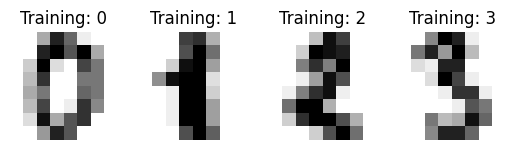

In [16]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
# The digits dataset
digits = datasets.load_digits()
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
  plt.subplot(2, 4, index + 1)
  plt.axis('off' )
  plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

  plt.title('Training: %i' % label)
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target,
test_size=test_size)
print(  "Dữ liệu training =   ", X_train.shape, y_train.shape)
print(  "Dữ liệu testing =   ", X_test.shape, y_test.shape)

In [17]:
######################
print(  "- Training ...  ")

# X_train.shape
print(  "- Train size = {}  ".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
print(  "- model - train complete  ")
from sklearn.metrics import accuracy_score
print(  "- Testing ...  ")
y_pred = model.predict(X_test)
print(  "- Acc = {}  ".format(accuracy_score(y_test, y_pred)))

- Training ...  
- Train size = (1437, 64)  
- model - train complete  
- Testing ...  
- Acc = 0.9833333333333333  
